<a href="https://colab.research.google.com/github/panghanwu/neural_network_python/blob/main/convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Configuration"""
import numpy as np


# image to column
def im2col(images, flt_h, flt_w, out_h, out_w, stride=1, pad=0):
  n_bt, n_ch, img_h, img_w = images.shape
  img_pad = np.pad(images, [(0,0), (0,0), (pad,pad), (pad,pad)], 'constant')
  cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))

  for h in range(flt_h):
    h_lim = h + stride*out_h
    for w in range(flt_w):
      w_lim = w + stride*out_w
      cols[:,:,h,w,:,:] = img_pad[:,:,h:h_lim:stride,w:w_lim:stride]

  cols = cols.transpose(1,2,3,0,4,5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
  return cols


# column to image
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride=1, pad=0):
  n_bt, n_ch, img_h, img_w = img_shape
  cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w).transpose(3,0,1,2,4,5)
  images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))

  for h in range(flt_h):
    h_lim = h + stride*out_h
    for w in range(flt_w):
      w_lim = w + stride*out_w
      images[:,:,h:h_lim:stride,w:w_lim:stride] += cols[:,:,h,w,:,:]

  return images[:, :, pad:img_h+pad, pad:img_w+pad]


# convolution layer
class ConvLayer:
  def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):
    self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
    
    self.w = wb_width*np.random.randn(n_flt, x_ch, flt_h, flt_w)
    self.b = wb_width*np.random.randn(1, n_flt)
    
    self.y_ch = n_flt
    self.y_h = (x_h - flt_h + 2*pad) // stride +1
    self.y_w = (x_w - flt_w + 2*pad) // stride +1 

    # AdaGrad
    self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
    self.h_b = np.zeros((1, n_flt)) + 1e-8

  def forward(self, x):
    n_bt = x.shape[0]
    x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
    y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
    
    self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
    self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
    
    u = np.dot(self.w_col, self.cols).T + self.b
    self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0,3,1,2)
    self.y = np.where(self.u < 0, 0.01*self.u, self.u)
  
  def backward(self, grad_y):
    n_bt = grad_y.shape[0]
    x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
    y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w

    delta = grad_y * np.where(self.u < 0, 0.01, 1)
    delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)

    grad_w = np.dot(self.cols, delta)
    self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
    self.grad_b = np.sum(delta, axis=0)

    grad_cols = np.dot(delta, self.w_col)
    x_shape = (n_bt, x_ch, x_h, x_w)
    self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
  
  def update(self, eta):
    self.h_w += self.grad_w**2
    self.w -= eta * self.grad_w / np.sqrt(self.h_w)

    self.h_b += self.grad_b**2
    self.b -= eta * self.grad_b / np.sqrt(self.h_b)


# maxpooling
class PoolingLayer:
  def __init__(self, x_ch, x_h, x_w, pool, pad):
    self.params = (x_ch, x_h, x_w, pool, pad)
       
    self.y_ch = x_ch
    self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1
    self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1
  
  def forward(self, x):
    n_bt = x.shape[0]
    x_ch, x_h, x_w, pool, pad = self.params
    y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w

    cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
    cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)

    y = np.max(cols, axis=1)
    self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0,3,1,2)

    self.max_index = np.argmax(cols, axis=1)

  def backward(self, grad_y):
    n_bt = grad_y.shape[0]

    x_ch, x_h, x_w, pool, pad = self.params
    y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w

    grad_y = grad_y.transpose(0,2,3,1)
    
    grad_cols = np.zeros((pool*pool, grad_y.size))
    grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1)
    grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
    grad_cols = grad_cols.transpose(5,0,1,2,3,4)
    grad_cols = grad_cols.reshape(y_ch*pool*pool, n_bt*y_h*y_w)

    x_shape = (n_bt, x_ch, x_h, x_w)
    self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)


# full connected
class BaseLayer:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)
    # AdaGrad
    self.h_w = np.zeros((n_upper,n)) + 1e-8
    self.h_b = np.zeros(n) + 1e-8
  
  def update(self, eta):
    self.h_w += self.grad_w**2
    self.w -= eta * self.grad_w / np.sqrt(self.h_w)

    self.h_b += self.grad_b**2
    self.b -= eta * self.grad_b / np.sqrt(self.h_b)


class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u < 0, 0.01*self.u, self.u)
  
  def backward(self, grad_y):
    delta = grad_y*np.where(self.u < 0, 0.01, 1)
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)


class OutputLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    u = np.dot(x, self.w) + self.b
    self.y = np.exp(u) / np.sum(np.exp(u), axis=1, keepdims=True)
  
  def backward(self, t):
    delta = self.y - t
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)


# metric
def get_loss(answer, predict, batch_size):
  cross_entropy = answer * np.log(predict+1e-7)
  return -np.sum(cross_entropy) / batch_size


def get_accuracy(answer, predict):
  result = np.argmax(answer, axis=1) == np.argmax(predict, axis=1)
  return np.sum(result) 


In [2]:
"""Fashion MNIST"""
from tensorflow.keras.datasets.fashion_mnist import load_data
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = load_data()

label = {
      0: 'T-shirt/top',
      1: 'Trouser',
      2: 'Pullover',
      3: 'Dress',
      4: 'Coat',
      5: 'Sandal',
      6: 'Shirt',
      7: 'Sneaker',
      8: 'Bag',
      9: 'Ankle boot'      
}

print(x_train.shape, x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


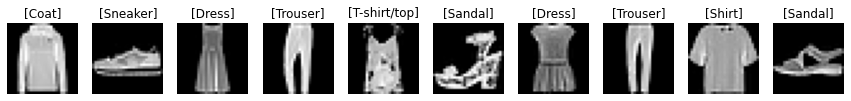

In [3]:
idx = np.random.randint(100, size=10)

plt.figure(figsize=(15,4))
for i, j in enumerate(idx):
  plt.subplot(1,10,i+1)
  plt.title('[{}]'.format(label[y_train[j]]))
  plt.axis('off')
  plt.imshow(x_train[j], 'gray')
plt.show()

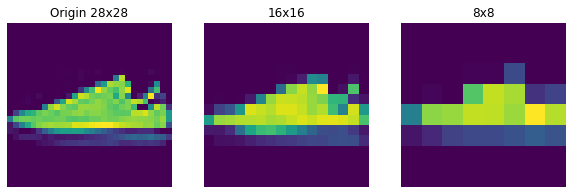

In [4]:
import cv2

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.axis('off')
plt.title('Origin 28x28')
plt.imshow(x_train[6])

size_1 = 16
plt.subplot(1,3,2)
plt.axis('off')
plt.title('%dx%d' % (size_1,size_1))
plt.imshow(cv2.resize(x_train[6], dsize=(size_1, size_1)))

size_2 = 8
plt.subplot(1,3,3)
plt.title('%dx%d' % (size_2,size_2))
plt.axis('off')
plt.imshow(cv2.resize(x_train[6], dsize=(size_2, size_2)))

plt.show()

In [5]:
# normalize and resize
size = 16
x_train_norm = np.zeros((x_train.shape[0],size,size))
x_test_norm = np.zeros((x_test.shape[0],size,size))

for i in range(x_train.shape[0]):
  x_train_norm[i] = cv2.resize(x_train[i], dsize=(size,size)) / 255

for i in range(x_test.shape[0]):
  x_test_norm[i] = cv2.resize(x_test[i], dsize=(size,size)) /255

# one-hot encoding
y_train_ohe = np.zeros((y_train.shape[0],10))
y_test_ohe = np.zeros((y_test.shape[0],10))

for i in range(y_train.shape[0]):
  y_train_ohe[i, y_train[i]] = 1.0

for i in range(y_test.shape[0]):
  y_test_ohe[i, y_test[i]] = 1.0

# split train to train and validation
index = np.arange(x_train.shape[0])
index_t = index[index%3 != 0]
index_v = index[index%3 == 0]

x_train_norm_t = x_train_norm[index_t,:]
y_train_ohe_t = y_train_ohe[index_t,:]
x_train_norm_v = x_train_norm[index_v,:]
y_train_ohe_v = y_train_ohe[index_v,:]

print(x_train_norm_t.shape, x_train_norm_v.shape)
print(y_train_ohe_t.shape, y_train_ohe_v.shape)

(40000, 16, 16) (20000, 16, 16)
(40000, 10) (20000, 10)


In [6]:
"""Initialize model"""
wb_width = 0.1  # scale of initial parameters
eta = 0.01  # learning rate
n_filter = 16  # number of filter

cl_1 = ConvLayer(1, size, size, n_filter, 3, 3 ,1 ,1)
pl_1 = PoolingLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 2, 0)
flitten_shape = pl_1.y_ch*pl_1.y_h*pl_1.y_w
ml_1 = MiddleLayer(flitten_shape, 128)
ol_1 = OutputLayer(128, 10)


# operation
def forward_propagation(x):
  n_bt = x.shape[0]
  images = x.reshape(n_bt, 1, size, size)

  cl_1.forward(images)
  pl_1.forward(cl_1.y)
  flatten = pl_1.y.reshape(n_bt, -1)
  ml_1.forward(flatten)
  ol_1.forward(ml_1.y)


def backpropagation(t):
  n_bt = t.shape[0]

  ol_1.backward(t)
  ml_1.backward(ol_1.grad_x)
  grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
  pl_1.backward(grad_img)
  cl_1.backward(pl_1.grad_x)


def update_wb():
  cl_1.update(eta)
  ml_1.update(eta)
  ol_1.update(eta)


def forward_sample(sample, answer, sample_size):
  index_rand = np.arange(len(answer))
  np.random.shuffle(index_rand)
  index_rand = index_rand[:sample_size]
  x = sample[index_rand,:]
  t = answer[index_rand,:]
  forward_propagation(x)
  return x, t


epoch:0/128 loss_train:14.470964 loss_valid:14.478752
epoch:16/128 loss_train:2.755838 loss_valid:2.691617
epoch:32/128 loss_train:2.673998 loss_valid:2.624549
epoch:48/128 loss_train:2.408382 loss_valid:2.415462
epoch:64/128 loss_train:2.11942 loss_valid:2.487682
epoch:80/128 loss_train:2.108537 loss_valid:2.405546
epoch:96/128 loss_train:2.10957 loss_valid:2.135531
epoch:112/128 loss_train:1.902661 loss_valid:2.27596


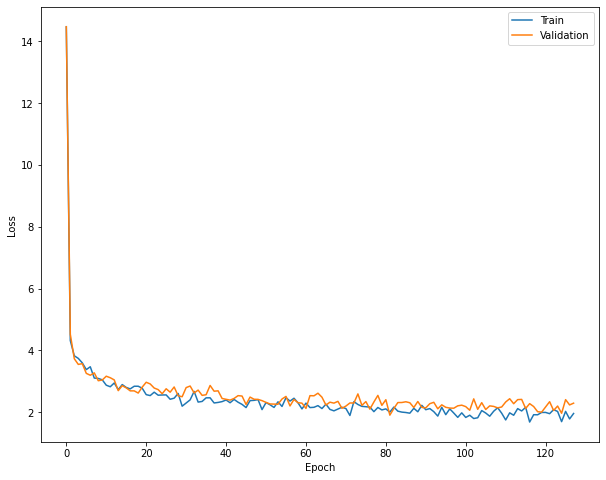

In [7]:
"""Training!"""
# parameters
epoch = 128
batch_size = 256
interval = 16
sample_size = 1024


train_loss_x = []
train_loss_y = []
valid_loss_x = []
valid_loss_y = []

n_batch = x_train_norm_t.shape[0] // batch_size

# training
for i in range(epoch):
  # evaluate loss
  x, t = forward_sample(x_train_norm_t, y_train_ohe_t, sample_size)
  loss_train = get_loss(ol_1.y, t, sample_size)

  x, t = forward_sample(x_train_norm_v, y_train_ohe_v, sample_size)
  loss_valid = get_loss(ol_1.y, t, sample_size) 

  train_loss_x.append(i)
  train_loss_y.append(loss_train)
  valid_loss_x.append(i)
  valid_loss_y.append(loss_valid)
  
  if i%interval == 0:
    print('epoch:'+str(i)+'/'+str(epoch),
       'loss_train:'+str(round(loss_train,6)),
       'loss_valid:'+str(round(loss_valid,6)))

  # batch
  index_rand = np.arange(x_train_norm_t.shape[0])
  np.random.shuffle(index_rand)

  for j in range(n_batch):
    mb_index = index_rand[j*batch_size:(j+1)*batch_size]
    x = x_train_norm_t[mb_index,:]
    t = y_train_ohe_t[mb_index,:]
    
    # training
    forward_propagation(x)
    backpropagation(t)
    update_wb()

# plot
plt.figure(figsize=(10,8))
plt.plot(train_loss_x, train_loss_y, label='Train')
plt.plot(valid_loss_x, valid_loss_y, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
print(cl_1.cols.shape)
print(cl_1.w_col.shape)

(9, 65536)
(16, 9)


In [9]:
"""Testing"""

x, t = forward_sample(x_test_norm, y_test_ohe, x_test_norm.shape[0])
count = get_accuracy(t, ol_1.y)
print('Accuracy:', str(round(count/x_test_norm.shape[0]*100,1))+'%')

Accuracy: 89.7%


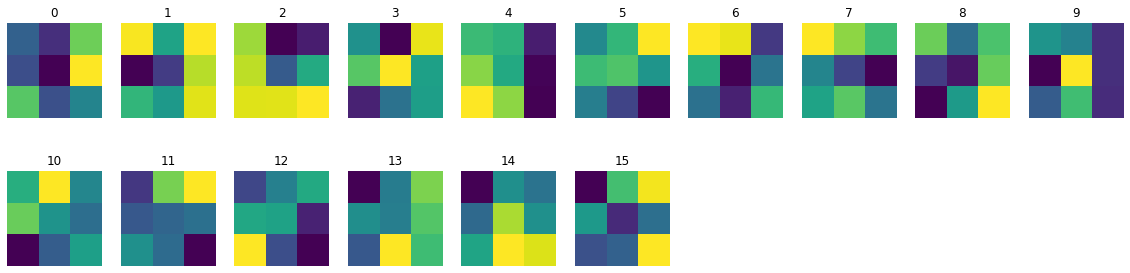

In [10]:
"""Trained filter"""

plt.figure(figsize=(20,5))
for i in range(n_filter):
  plt.subplot(n_filter//10+1,10,i+1)
  plt.axis('off')
  plt.title(i)
  plt.imshow(cl_1.w[i,0,:,:])
plt.show()

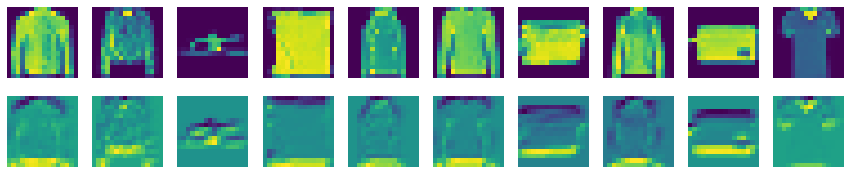

In [11]:
"""Feature map"""

flt_n = 5
flt = cl_1.w[flt_n,0,:,:].reshape(1, 9)
index_img = np.arange(50,60,1)

plt.figure(figsize=(15,3))

for i, j in enumerate(index_img):
  test_img = x_test_norm[j]
  conv_img = test_img.reshape((1,1,size,size))
  conv_img = im2col(conv_img, 3, 3, size, size, 1, 1)

  conv_img = np.dot(flt, conv_img)

  plt.subplot(2,len(index_img),1+i)
  plt.axis('off')
  plt.imshow(test_img)
  
  plt.subplot(2,len(index_img),1+len(index_img)+i)
  plt.axis('off')
  plt.imshow(conv_img.reshape(size, size))

plt.show()

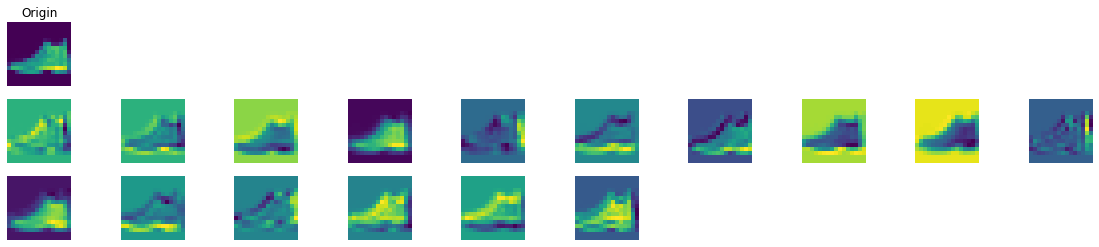

In [12]:
test_img = x_test_norm[0]

plt.figure(figsize=(20,4))
plt.subplot((n_filter//10+2),10,1)
plt.axis('off')
plt.title('Origin')
plt.imshow(test_img)

for i in range(n_filter):
  conv_img = test_img.reshape((1,1,size,size))
  conv_img = im2col(conv_img, 3, 3, size, size, 1, 1)

  flt = cl_1.w[i,0,:,:].reshape(1, 9)

  conv_img = np.dot(flt, conv_img)
  
  plt.subplot(n_filter//10+2,10,11+i)
  plt.axis('off')
  plt.imshow(conv_img.reshape(size, size))

plt.show()

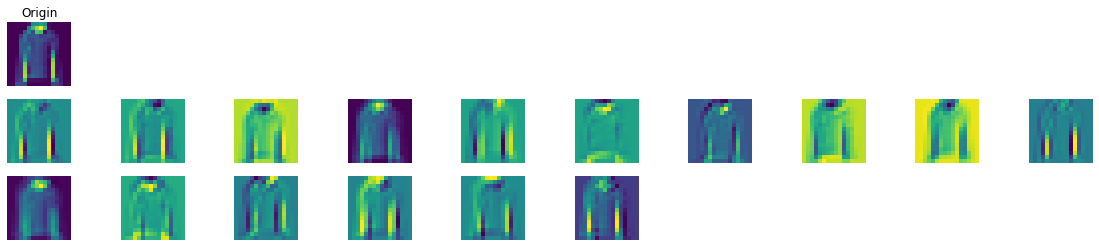

In [13]:
test_img = x_test_norm[6]

plt.figure(figsize=(20,4))
plt.subplot((n_filter//10+2),10,1)
plt.axis('off')
plt.title('Origin')
plt.imshow(test_img)

for i in range(n_filter):
  conv_img = test_img.reshape((1,1,size,size))
  conv_img = im2col(conv_img, 3, 3, size, size, 1, 1)

  flt = cl_1.w[i,0,:,:].reshape(1, 9)

  conv_img = np.dot(flt, conv_img)
  
  plt.subplot(n_filter//10+2,10,11+i)
  plt.axis('off')
  plt.imshow(conv_img.reshape(size, size))

plt.show()